# Theano, Lasagne
и с чем их едят

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [1]:
!pip install Theano
!pip install lasagne

You are using pip version 8.1.2, however version 9.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
def sum_squares(N):
    return (np.arange(N)**2).sum()

In [3]:
%%time
sum_squares(10**8)

CPU times: user 380 ms, sys: 724 ms, total: 1.1 s
Wall time: 1.1 s


662921401752298880

# theano teaser

Как сделать то же самое

In [4]:
import theano
import theano.tensor as T

In [5]:
#будущий параметр функции
N = T.scalar("a dimension",dtype='int32')


#рецепт получения суммы квадратов
result = (T.arange(N)**2).sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs = [N],outputs=result)

In [6]:
%%time
sum_function(10**8)

CPU times: user 476 ms, sys: 568 ms, total: 1.04 s
Wall time: 1.04 s


array(662921401752298880)

# Как оно работает?
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [7]:
#входы
example_input_integer = T.scalar("вход - одно число(пример)",dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодится



input_vector = T.vector("вход - вектор целых чисел", dtype='int32')


In [8]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector


In [9]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [10]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector("вход - вектор целых чисел", dtype='float32')
my_vector2 = T.vector("вход - вектор целых чисел", dtype='float32')

In [11]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1.0)

In [12]:
print my_transformation
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [13]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [14]:
#можно вызвать вот-так:
print "using python lists:"
print my_function([1,2,3],[4,5,6])
print

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print "using numpy arrays:"
print my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float'))


using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]

using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [15]:
#словарик значений для входов
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print my_transformation.eval(my_function_inputs)


#можно вычислять преобразования на ходу
print "сумма 2 векторов", (my_vector + my_vector2).eval(my_function_inputs)

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print "форма первого вектора", my_vector.shape.eval({
        my_vector:[1,2,3]
    })


[  2.1721766    5.23752832  15.77397728]
сумма 2 векторов [ 5.  7.  9.]
форма первого вектора [3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам

In [16]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

my_vector = T.vector("вход - вектор целых чисел", dtype='float32')
my_vector2 = T.vector("вход - вектор целых чисел", dtype='float32')
my_transformation = ((my_vector - my_vector2)**2).mean()
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

compute_mse = theano.function(inputs, outputs, allow_input_downcast=True)

In [17]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print 'Wrong result:'
                print 'mse(%s,%s)'%(el,el_2)
                print "should be: %f, but your function returned %f"%(true_mse,my_mse)
                raise ValueError,"Что-то не так"

print "All tests passed"
            
    

All tests passed


# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [18]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [19]:

#получить (численное) значение переменной
print "initial value",shared_vector_1.get_value()

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [20]:
#задать новое значение
shared_vector_1.set_value( np.arange(5) )

#проверим значение
print "new value", shared_vector_1.get_value()

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

new value [ 0.  1.  2.  3.  4.]


# Теперь сам

In [21]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = input_scalar * shared_vector_1


shared_times_n = theano.function(inputs = [input_scalar], outputs = scalar_times_shared)


In [22]:
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [  0.   5.  10.  15.  20.]
shared_times_n(-0.5) [-0.  -0.5 -1.  -1.5 -2. ]


In [23]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1,0,1])
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


shared: [-1.  0.  1.]
shared_times_n(5) [-5.  0.  5.]
shared_times_n(-0.5) [ 0.5 -0.  -0.5]


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [24]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

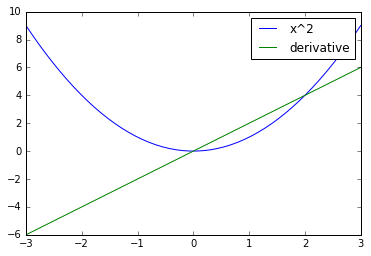

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = map(fun,x)
x_squared_der = map(grad,x)

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# теперь сам

In [26]:

my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar,der_by_vector = T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector)


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)


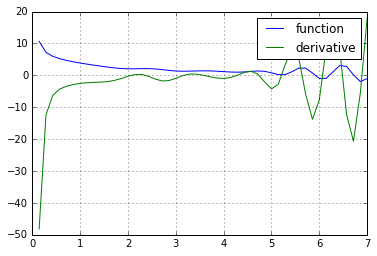

In [27]:
#график функции и твоей производной
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [28]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1:scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [29]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print "initial shared value:" ,shared_vector_1.get_value()

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print "compute_and_save(2) returns",compute_and_save(2)

#проверим, что в shared_vector_1
print "new shared value:" ,shared_vector_1.get_value()



initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value: [ 0.  2.  4.  6.  8.]


# Логистическая регрессия
Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [30]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print "y [форма - %s]:"%(str(y.shape)),y[:10]

print "X [форма - %s]:"%(str(X.shape))
print X[:3]

y [форма - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [31]:
# переменные и входы
shared_weights = theano.shared(np.zeros(X.shape[1], dtype='float64'))
input_X = T.matrix('X', dtype='float64')
input_y = T.vector('y', dtype='float64')

In [32]:
predicted_y = input_X.dot(shared_weights)
loss = T.log(1.0 + T.exp(predicted_y - input_y.mean())).sum()

grad = T.grad(loss, shared_weights)



updates = {
    shared_weights: shared_weights - grad
}

In [33]:
train_function = theano.function(inputs = [input_X, input_y], outputs = loss, updates = updates)
predict_function = theano.function(inputs = [input_X], outputs = predicted_y)

In [34]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

/home/alexander/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loss at iter 0:126.1239
train auc: 0.531373626374
test auc: 0.412202380952
loss at iter 1:0.0000
train auc: 0.531373626374
test auc: 0.412202380952
loss at iter 2:0.0000
train auc: 0.531373626374
test auc: 0.412202380952
loss at iter 3:0.0000
train auc: 0.531373626374
test auc: 0.412202380952
loss at iter 4:0.0000
train auc: 0.531373626374
test auc: 0.412202380952
resulting weights:


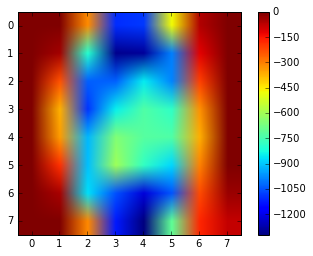

In [35]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print "loss at iter %i:%.4f"%(i,loss_i)
    print "train auc:",roc_auc_score(y_train,predict_function(X_train))
    print "test auc:",roc_auc_score(y_test,predict_function(X_test))

    
print "resulting weights:"
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()